In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from helperfxns import *
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import itertools
import fbprophet
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import the sales data
df = pd.read_csv('circ_sales.csv')

In [3]:
df.head()

,Unnamed: 0,net_sales,30_day_sales_mean,Month,natural_log
0,2017-08-01,6728.97,NaN,8,8.814177
1,2017-08-02,8799.69,NaN,8,9.082472
2,2017-08-03,9432.39,NaN,8,9.151905
3,2017-08-04,13329.42,NaN,8,9.497729
4,2017-08-05,12139.54,NaN,8,9.404223


In [4]:
# reconfigure the dataframe for use in prophet
ts = df.rename(columns={'Unnamed: 0': 'ds',
                        'net_sales': 'y'})

In [5]:
ts.ds = pd.to_datetime(ts.ds)

In [7]:
ts.drop(['30_day_sales_mean', 'Month', 'natural_log'], axis=1, inplace=True)

In [8]:
ts.tail()

,ds,y
817,2019-10-27,9153.85
818,2019-10-28,6860.01
819,2019-10-29,4698.24
820,2019-10-30,6686.22
821,2019-10-31,7117.01


In [9]:
# instantiate the model
model = proph(interval_width=0.95)

In [10]:
model.fit(ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
#make the dates to be predicted
future_dates = model.make_future_dataframe(periods=14, freq='D')
future_dates.tail()

,ds
831,2019-11-10
832,2019-11-11
833,2019-11-12
834,2019-11-13
835,2019-11-14


In [12]:
# make the forecast
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-08-01,9265.818267,582.176307,11389.093234,9265.818267,9265.818267,-3156.355849,-3156.355849,-3156.355849,-2621.707208,-2621.707208,-2621.707208,-534.648641,-534.648641,-534.648641,0.0,0.0,0.0,6109.462418
1,2017-08-02,9261.529235,1685.070361,12779.149081,9261.529235,9261.529235,-1971.074593,-1971.074593,-1971.074593,-1444.395096,-1444.395096,-1444.395096,-526.679497,-526.679497,-526.679497,0.0,0.0,0.0,7290.454642
2,2017-08-03,9257.240204,3910.177591,14573.130550,9257.240204,9257.240204,-12.224085,-12.224085,-12.224085,510.639441,510.639441,510.639441,-522.863526,-522.863526,-522.863526,0.0,0.0,0.0,9245.016119
3,2017-08-04,9252.951172,6770.570682,17727.788302,9252.951172,9252.951172,3094.490598,3094.490598,3094.490598,3617.428324,3617.428324,3617.428324,-522.937726,-522.937726,-522.937726,0.0,0.0,0.0,12347.441770
4,2017-08-05,9248.662140,7558.472568,18578.141578,9248.662140,9248.662140,3726.222273,3726.222273,3726.222273,4252.789388,4252.789388,4252.789388,-526.567114,-526.567114,-526.567114,0.0,0.0,0.0,12974.884414


In [13]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
831,2019-11-10,7313.447555,2033.276466,12620.360703
832,2019-11-11,5710.374429,655.030367,11142.675192
833,2019-11-12,5832.526956,360.764673,11325.798124
834,2019-11-13,6872.123789,1244.024978,12127.652018
835,2019-11-14,8698.165786,3254.324835,14044.754614


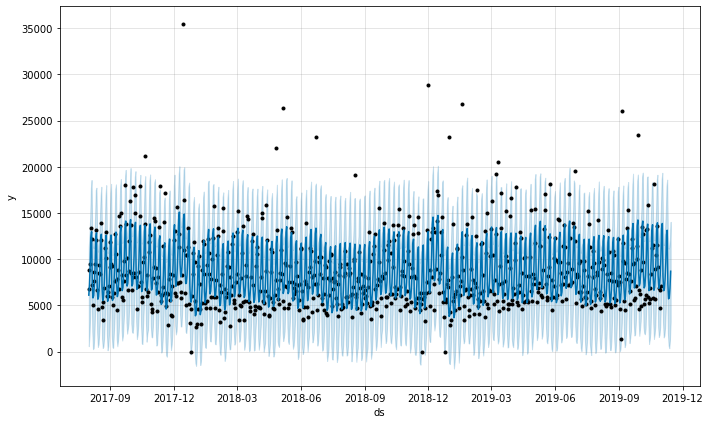

In [14]:
model.plot(forecast, uncertainty=True)
plt.show()

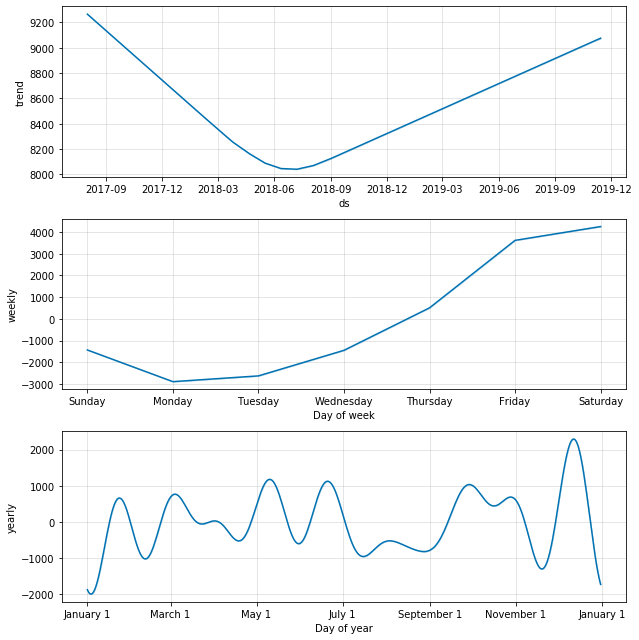

In [15]:
# take a look at the underlying trends
model.plot_components(forecast)
plt.show()

Now, a look at the evaluation metrics

In [22]:
# using prophet's built in cross validation metrics
df_cv = cross_validation(model, initial='800 days', period='90 days', horizon = '14 days')
df_cv

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-10-17 00:00:00 and 2019-10-17 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-18,13113.695438,7597.939302,18657.066892,11253.03,2019-10-17
1,2019-10-19,13801.485767,8536.092703,19214.494093,11523.27,2019-10-17
2,2019-10-20,8125.698249,2605.761837,13405.607698,5779.09,2019-10-17
3,2019-10-21,6594.052832,1460.848768,11626.369254,18097.35,2019-10-17
4,2019-10-22,7033.621390,1442.169342,12451.551806,5720.16,2019-10-17
5,2019-10-23,8233.218319,3100.324520,13251.930335,8901.61,2019-10-17
6,2019-10-24,10251.373789,5193.704715,15709.552118,10500.06,2019-10-17
7,2019-10-25,13392.741285,8155.960939,18501.435059,13611.38,2019-10-17
8,2019-10-26,14096.359355,9009.963149,19522.089626,11518.79,2019-10-17
9,2019-10-27,8422.221878,3112.467111,13855.488324,9153.85,2019-10-17


In [23]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,coverage
0,1 days,3.462076e+06,1860.665438,1860.665438,0.165348,1.0
1,2 days,5.190267e+06,2278.215767,2278.215767,0.197706,1.0
2,3 days,5.506570e+06,2346.608249,2346.608249,0.406052,1.0
3,4 days,1.323258e+08,11503.297168,11503.297168,0.635634,0.0
4,5 days,1.725181e+06,1313.461390,1313.461390,0.229620,1.0
5,6 days,4.467474e+05,668.391681,668.391681,0.075087,1.0
6,7 days,6.184483e+04,248.686211,248.686211,0.023684,1.0
7,8 days,4.780289e+04,218.638715,218.638715,0.016063,1.0
8,9 days,6.643864e+06,2577.569355,2577.569355,0.223771,1.0
9,10 days,5.352797e+05,731.628122,731.628122,0.079926,1.0


In [25]:
df_p['rmse'].mean()

2242.5251653881382

Adding in US holidays:

In [26]:
model = proph(interval_width=0.95)

In [27]:
model.add_country_holidays(country_name='US')
model.fit(ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future_dates = model.make_future_dataframe(periods=14, freq='D')
future_dates.tail()

,ds
831,2019-11-10
832,2019-11-11
833,2019-11-12
834,2019-11-13
835,2019-11-14


In [29]:
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-08-01,9395.188435,1042.949567,11160.039243,9395.188435,9395.188435,0.0,0.0,0.0,0.0,...,-2588.840065,-2588.840065,-2588.840065,-519.544952,-519.544952,-519.544952,0.0,0.0,0.0,6286.803419
1,2017-08-02,9390.109892,2132.237462,12587.927018,9390.109892,9390.109892,0.0,0.0,0.0,0.0,...,-1446.347977,-1446.347977,-1446.347977,-511.125917,-511.125917,-511.125917,0.0,0.0,0.0,7432.635998
2,2017-08-03,9385.031348,4377.944923,14582.440462,9385.031348,9385.031348,0.0,0.0,0.0,0.0,...,624.003123,624.003123,624.003123,-508.247474,-508.247474,-508.247474,0.0,0.0,0.0,9500.786997
3,2017-08-04,9379.952805,7262.068003,17907.673653,9379.952805,9379.952805,0.0,0.0,0.0,0.0,...,3601.886432,3601.886432,3601.886432,-510.682611,-510.682611,-510.682611,0.0,0.0,0.0,12471.156626
4,2017-08-05,9374.874261,7570.155283,18413.896035,9374.874261,9374.874261,0.0,0.0,0.0,0.0,...,4212.476425,4212.476425,4212.476425,-518.088883,-518.088883,-518.088883,0.0,0.0,0.0,13069.261803


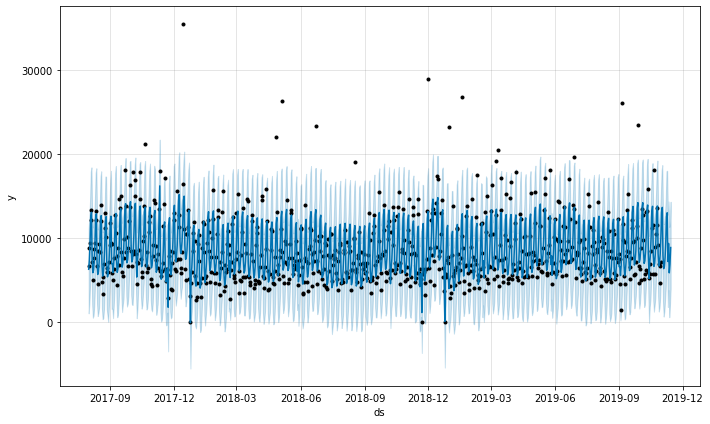

In [30]:
model.plot(forecast, uncertainty=True)
plt.show()

In [31]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
831,2019-11-10,9114.812089,1815.372332,12792.572701,9110.298048,9117.653743,0.0,0.0,0.0,0.0,...,-1467.855006,-1467.855006,-1467.855006,-432.857314,-432.857314,-432.857314,0.0,0.0,0.0,7214.099769
832,2019-11-11,9117.103215,3806.899647,14358.227251,9112.028705,9120.428476,0.0,0.0,0.0,0.0,...,-2935.322933,-2935.322933,-2935.322933,-550.791070,-550.791070,-550.791070,0.0,0.0,0.0,9358.571127
833,2019-11-12,9119.394342,582.555045,11330.593664,9113.671737,9123.348640,0.0,0.0,0.0,0.0,...,-2588.840065,-2588.840065,-2588.840065,-665.667789,-665.667789,-665.667789,0.0,0.0,0.0,5864.886488
834,2019-11-13,9121.685468,1963.396791,11990.328767,9115.283319,9126.130525,0.0,0.0,0.0,0.0,...,-1446.347977,-1446.347977,-1446.347977,-774.557476,-774.557476,-774.557476,0.0,0.0,0.0,6900.780015
835,2019-11-14,9123.976594,3966.545708,14319.839196,9117.000744,9128.909866,0.0,0.0,0.0,0.0,...,624.003123,624.003123,624.003123,-874.459824,-874.459824,-874.459824,0.0,0.0,0.0,8873.519893


In [44]:
df_cv = cross_validation(model, initial='786 days', period='30 days', horizon = '14 days')
df_cv

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-10-17 00:00:00 and 2019-10-17 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-18,13158.524171,8050.970473,18361.048269,11253.03,2019-10-17
1,2019-10-19,13795.843655,8898.845562,18712.355963,11523.27,2019-10-17
2,2019-10-20,8093.974899,2954.227360,13244.392071,5779.09,2019-10-17
3,2019-10-21,6508.541290,1297.418213,11686.353444,18097.35,2019-10-17
4,2019-10-22,7022.109295,1660.318310,12015.849921,5720.16,2019-10-17
5,2019-10-23,8156.517145,3372.463670,13229.977190,8901.61,2019-10-17
6,2019-10-24,10268.974348,5234.128257,15033.695388,10500.06,2019-10-17
7,2019-10-25,13247.158458,7800.061063,18569.356396,13611.38,2019-10-17
8,2019-10-26,13897.920075,9162.219869,19160.543868,11518.79,2019-10-17
9,2019-10-27,8199.370566,3131.157267,13553.157093,9153.85,2019-10-17


In [45]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,coverage
0,1 days,3.630908e+06,1905.494171,1905.494171,0.169332,1.0
1,2 days,5.164591e+06,2272.573655,2272.573655,0.197216,1.0
2,3 days,5.358692e+06,2314.884899,2314.884899,0.400562,1.0
3,4 days,1.343005e+08,11588.808710,11588.808710,0.640359,0.0
4,5 days,1.695072e+06,1301.949295,1301.949295,0.227607,1.0
5,6 days,5.551634e+05,745.092855,745.092855,0.083703,1.0
6,7 days,5.340058e+04,231.085652,231.085652,0.022008,1.0
7,8 days,1.326573e+05,364.221542,364.221542,0.026759,1.0
8,9 days,5.660260e+06,2379.130075,2379.130075,0.206543,1.0
9,10 days,9.110310e+05,954.479434,954.479434,0.104271,1.0


In [46]:
df_p['rmse'].mean()

2242.1880796618475

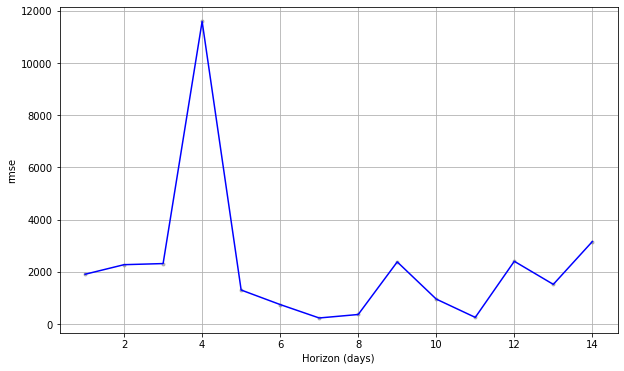

In [43]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

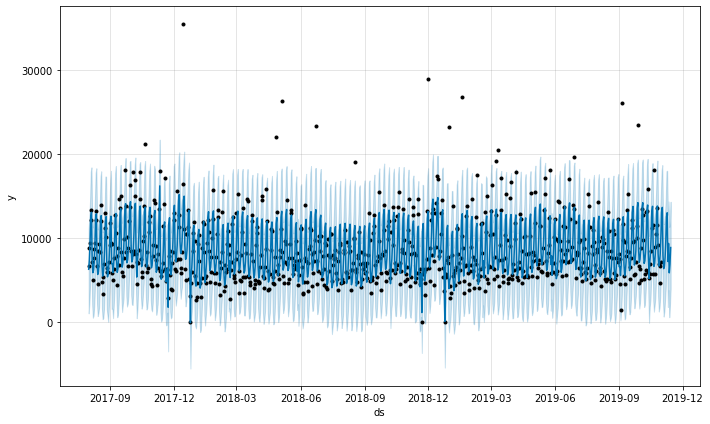

In [51]:
fig = model.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), model, forecast)